<a href="https://colab.research.google.com/github/SrivenkateswaraRao/Research-Project/blob/master/Pest_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from os import listdir
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import files
files.upload() 

In [50]:
import CreatePestImageData as Imagedataset
import SupportingFunctions as support

In [ ]:
support.DownLoadFiles('1aXb25Wp9sG7mL6AQgYY9ElrGcERi95JU',drive)

In [ ]:
support.Unzip('/content/GREENPATROL_DB_V3.0.zip','/content/Pests/Images')

In [ ]:
support.fileCount('/content/Pests/Images')

4330


In [ ]:
dataSet = Imagedataset.createImageDataset()

In [45]:
class_object = {0 : 'egg_wf' ,
                1 : 'egg_bt', 2 : 'egg_ta', 3 : 'wf', 4 : 'bt', 5 : 'tomato'}

In [ ]:
dataSet.prepare_dataset('/content/Pests/Labels' , class_object ,32, '/content/Pests/Images/',  test_size=11241 )

In [ ]:
listdir('/content/Pests/Labels')

In [ ]:
(trainY , trainX) , (testY , testX ) = (dataSet.trainY , dataSet.trainX ) , (dataSet.testY , dataSet.testX )


In [ ]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [9]:
import tensorflow as tf
from keras import models
from keras.applications.resnet50 import ResNet50
resNet = ResNet50(input_shape=[32,32,3], include_top=False, pooling='avg',weights='imagenet')
resNet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [26]:
from keras.models import Model
layerName = 'conv1'
mymodel = Model(inputs= resNet.input , outputs=resNet.get_layer(layerName).output)
mymodel.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 38, 38, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        9472      
Total params: 9,472
Trainable params: 9,472
Non-trainable params: 0
_________________________________________________________________


In [12]:
from keras import applications
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization

In [31]:
model= models.Sequential()
model.add(mymodel)
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))
model.layers[0].trainable = True

# compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 16, 16, 64)        9472      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 16)        9232      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 32)          4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
global_average_pooling2d_12  (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)              

In [33]:
from tensorflow.keras.utils import to_categorical
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [34]:
filepath="/content/drive/My Drive/Models/ResNet50/weights-{epoch:02d}-{accuracy:.3f}.hdf5"
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='accuracy',
                               verbose=1, mode='max',save_best_only=True)

callbacks_list = [checkpoint]

In [ ]:
tf.config.experimental_run_functions_eagerly(True)


In [35]:
model.fit(trainX,trainY,verbose=1,epochs=50,validation_data=(testX,testY),callbacks=[checkpoint])

Train on 44964 samples, validate on 11241 samples
Epoch 1/50
44964/44964 [==============================] - 16s 358us/step - loss: 0.9559 - accuracy: 0.6271 - val_loss: 0.9756 - val_accuracy: 0.6483

Epoch 00001: accuracy improved from -inf to 0.62715, saving model to /content/drive/My Drive/Models/ResNet50/weights-01-0.627.hdf5
Epoch 2/50
44964/44964 [==============================] - 16s 349us/step - loss: 0.9128 - accuracy: 0.6361 - val_loss: 14.5042 - val_accuracy: 0.0131

Epoch 00002: accuracy improved from 0.62715 to 0.63611, saving model to /content/drive/My Drive/Models/ResNet50/weights-02-0.636.hdf5
Epoch 3/50
44964/44964 [==============================] - 16s 349us/step - loss: 0.9851 - accuracy: 0.6112 - val_loss: 0.9868 - val_accuracy: 0.6013

Epoch 00003: accuracy did not improve from 0.63611
Epoch 4/50
44964/44964 [==============================] - 16s 352us/step - loss: 0.9578 - accuracy: 0.6202 - val_loss: 1.1007 - val_accuracy: 0.5927

Epoch 00004: accuracy did not imp

In [41]:
from keras.models import load_model
model_Saved = load_model("/content/drive/My Drive/Models/ResNet50/weights-50-0.746.hdf5")
model_Saved.fit(trainX,trainY,verbose=1,epochs=50,validation_data=(testX,testY),callbacks=[checkpoint])

Train on 44964 samples, validate on 11241 samples
Epoch 1/50
44964/44964 [==============================] - 18s 403us/step - loss: 0.6202 - accuracy: 0.7431 - val_loss: 0.8342 - val_accuracy: 0.6835

Epoch 00001: accuracy did not improve from 0.74569
Epoch 2/50
44964/44964 [==============================] - 18s 398us/step - loss: 0.6159 - accuracy: 0.7450 - val_loss: 0.8238 - val_accuracy: 0.6861

Epoch 00002: accuracy did not improve from 0.74569
Epoch 3/50
44964/44964 [==============================] - 18s 406us/step - loss: 0.6143 - accuracy: 0.7459 - val_loss: 0.8229 - val_accuracy: 0.6880

Epoch 00003: accuracy improved from 0.74569 to 0.74589, saving model to /content/drive/My Drive/Models/ResNet50/weights-03-0.746.hdf5
Epoch 4/50
44964/44964 [==============================] - 18s 409us/step - loss: 0.6147 - accuracy: 0.7470 - val_loss: 0.8194 - val_accuracy: 0.6937

Epoch 00004: accuracy improved from 0.74589 to 0.74700, saving model to /content/drive/My Drive/Models/ResNet50/we

In [42]:
import json
history_dict = model.history.history
json.dump(str(history_dict), open('/content/drive/My Drive/Models/ResNet50/History/ResNet50_History4.json', 'w'))

In [43]:
import matplotlib.pyplot as plt
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
   
  plt.imshow(img[...,0], cmap=plt.cm.binary)
 
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
   
  plt.xlabel("{} {:2.0f}% ({})".format(class_object[predicted_label],
                                100*np.max(predictions_array),
                                class_object[true_label]),
                                color=color)

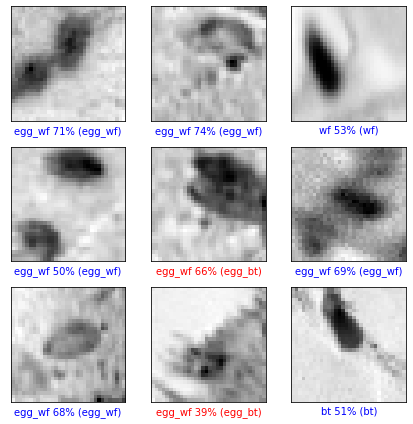

In [46]:
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
test_images = testX[:num_images]
predictions = model.predict(testX_Pred)
for i in range(num_images):    
    plt.subplot(num_rows, num_cols, i+1)   
    plot_image(i, predictions, testY_Pred, testX_Pred)    
 
plt.tight_layout()
plt.show()

In [47]:
acc = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']
loss  =  model.history.history['loss']
val_loss = model.history.history['val_loss']

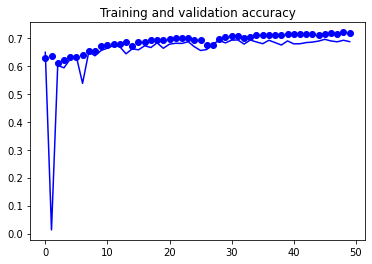

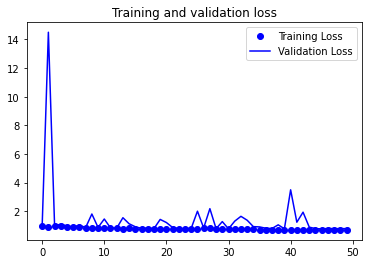

In [51]:
support.GenerateGraphs(acc,val_accuracy,loss,val_loss)

In [52]:
support.PrintMetrics(testX_Pred,testY_Pred,model)

Accuracy: 0.707677
Precision: 0.446056
Recall: 0.472665
F1 score: 0.400426
Cohens kappa: 0.540615


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
